In [1]:
from keras.models import Model
from keras.layers import GlobalAveragePooling2D , Dropout , Dense
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from keras.models import load_model
import matplotlib.pyplot as plt

### Compile model

In [2]:
CLASSES = 4

In [3]:
base_model = ResNet50(input_shape=(90, 120, 3),weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dense(512, activation='relu')(x)
#x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

### Load Images

In [4]:
path = "D:/test/dataset/"

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.5,
                                   zoom_range=[0.8, 2.0],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

validate_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

In [6]:
train_generator = train_datagen.flow_from_directory(path+'train/',
                                                  batch_size=10,
                                                    target_size=(90,120),
                                                  class_mode='categorical')

validation_generator = validate_datagen.flow_from_directory(path+'val/',
                                                      batch_size=10,
                                                        target_size=(90,120),
                                                      class_mode='categorical')

test_generator = test_datagen.flow_from_directory(path+'test/',
                                                      batch_size=10,
                                                        target_size=(90,120),
                                                      class_mode='categorical')

Found 424 images belonging to 4 classes.
Found 124 images belonging to 4 classes.
Found 64 images belonging to 4 classes.


### Train model (only the top layers)

In [7]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=["accuracy"])
history = model.fit(
  train_generator,
  validation_data=validation_generator,
  steps_per_epoch=train_generator.n//10,
  epochs=50,
  validation_steps=validation_generator.n//10
)

Epoch 1/50
42/42 [==============================] - 21s 438ms/step - loss: 1.5475 - accuracy: 0.2924 - val_loss: 1.4013 - val_accuracy: 0.2583
Epoch 2/50
42/42 [==============================] - 17s 398ms/step - loss: 1.4045 - accuracy: 0.2981 - val_loss: 1.4575 - val_accuracy: 0.3167
Epoch 3/50
42/42 [==============================] - 17s 410ms/step - loss: 1.4070 - accuracy: 0.3005 - val_loss: 1.3768 - val_accuracy: 0.2417
Epoch 4/50
42/42 [==============================] - 18s 438ms/step - loss: 1.3360 - accuracy: 0.3331 - val_loss: 1.2906 - val_accuracy: 0.4083
Epoch 5/50
42/42 [==============================] - 18s 426ms/step - loss: 1.2795 - accuracy: 0.3826 - val_loss: 1.4669 - val_accuracy: 0.2750
Epoch 6/50
42/42 [==============================] - 19s 450ms/step - loss: 1.3383 - accuracy: 0.3327 - val_loss: 1.2256 - val_accuracy: 0.4083
Epoch 7/50
42/42 [==============================] - 17s 417ms/step - loss: 1.2714 - accuracy: 0.3677 - val_loss: 1.2415 - val_accuracy: 0.3917

### Train (fine-tune bottom 2 layers)

In [8]:
for layer in model.layers[:168]:
    layer.trainable = False
for layer in model.layers[168:]:
    layer.trainable = True

#SGD(lr=0.0001, momentum=0.9)
model.compile(optimizer=Adam(), loss='categorical_crossentropy',metrics=["accuracy"])
history = model.fit(
  train_generator,
  validation_data=validation_generator,
  steps_per_epoch=train_generator.n//10,
  epochs=50,
  validation_steps=validation_generator.n//10
)

Epoch 1/50
42/42 [==============================] - 24s 488ms/step - loss: 5.3990 - accuracy: 0.3301 - val_loss: 22.4954 - val_accuracy: 0.2833
Epoch 2/50
42/42 [==============================] - 20s 471ms/step - loss: 1.3452 - accuracy: 0.3708 - val_loss: 7.3153 - val_accuracy: 0.2333
Epoch 3/50
42/42 [==============================] - 20s 472ms/step - loss: 1.2637 - accuracy: 0.4084 - val_loss: 4.0242 - val_accuracy: 0.2750
Epoch 4/50
42/42 [==============================] - 20s 469ms/step - loss: 1.1509 - accuracy: 0.4672 - val_loss: 1.7723 - val_accuracy: 0.3083
Epoch 5/50
42/42 [==============================] - 19s 460ms/step - loss: 1.0935 - accuracy: 0.5135 - val_loss: 3.1384 - val_accuracy: 0.2583
Epoch 6/50
42/42 [==============================] - 19s 456ms/step - loss: 1.0625 - accuracy: 0.5310 - val_loss: 1.5085 - val_accuracy: 0.3000
Epoch 7/50
42/42 [==============================] - 19s 460ms/step - loss: 1.0258 - accuracy: 0.5285 - val_loss: 0.8438 - val_accuracy: 0.650

### Evaluate model & Visualize performance

In [9]:
model.evaluate(test_generator)

7/7 [==============================] - 2s 283ms/step - loss: 2.1591 - accuracy: 0.3750


[2.159130334854126, 0.375]

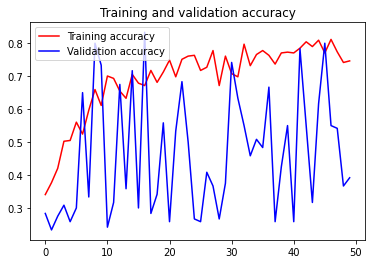

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
fig = plt.gcf()
fig.savefig('from_ResNet50.png',dpi=fig.dpi)
plt.show()



### Save model

In [11]:
model.save('from_ResNet50.h5')
model.save_weights('from_ResNet50_weights.h5')